In [1]:
import numpy as np
import os
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# tensorflow and related layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation

# reports
from sklearn.metrics import confusion_matrix, classification_report

# progress status
from tqdm.notebook import tqdm

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
print("Tensorflow version:", tf.__version__)
print("Keras version:", keras.__version__)

Tensorflow version: 2.5.0
Keras version: 2.5.0


Define Model parameters

In [3]:
model_params = {
    "n_epochs": 20,
    "batch_size": 32,
    "activation_output": "softmax",
    "loss": "sparse_categorical_crossentropy",
    "optimizer": keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    "metrics": ["accuracy"]
}

# Load the Dataset

Load the data from Keras

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

Explore the data related to its shape, data type, and min/max value in the matrix

In [5]:
print("X train data shape:", X_train_full.shape)
print("y train data shape:", y_train_full.shape)
print("X test data shape:", X_test.shape)
print("y test data shape:", y_test.shape)

X train data shape: (60000, 28, 28)
y train data shape: (60000,)
X test data shape: (10000, 28, 28)
y test data shape: (10000,)


In [6]:
print("X train data type:", X_train_full.dtype)
print("y train data type:", y_train_full.dtype)
print("X test data type:", X_test.dtype)
print("y test data type:", y_test.dtype)

X train data type: uint8
y train data type: uint8
X test data type: uint8
y test data type: uint8


In [7]:
print("X train type:", type(X_train_full))
print("y train type:", type(y_train_full))
print("X test type:", type(X_test))
print("y test type:", type(y_test))

X train type: <class 'numpy.ndarray'>
y train type: <class 'numpy.ndarray'>
X test type: <class 'numpy.ndarray'>
y test type: <class 'numpy.ndarray'>


In [8]:
print("Maximum matrix value:", X_train_full.max())
print("Minimum matrix value:", X_train_full.min())

Maximum matrix value: 255
Minimum matrix value: 0


# Split the train data into *train* and *validation* sets

In [9]:
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [10]:
print("X validation data shape:", X_valid.shape)
print("y validation data shape:", y_valid.shape)

X validation data shape: (5000, 28, 28)
y validation data shape: (5000,)


# Normalize the data

In [11]:
# normalization
def normalize_pics(data):
    return data / 255.

In [12]:
X_train_normalized = normalize_pics(X_train)
X_valid_normalized = normalize_pics(X_valid)
X_test_normalized = normalize_pics(X_test)

In [13]:
print("Maximum matrix value:", X_train_normalized.max())
print("Minimum matrix value:", X_train_normalized.min())

Maximum matrix value: 1.0
Minimum matrix value: 0.0


In [14]:
print("X train normalized data shape:", X_train_normalized.shape)
print("X validation normalized data shape:", X_valid_normalized.shape)
print("X test normalized data shape:", X_test_normalized.shape)

X train normalized data shape: (55000, 28, 28)
X validation normalized data shape: (5000, 28, 28)
X test normalized data shape: (10000, 28, 28)


# Scale the inputs to mean 0 and standard deviation 1

Compute the mean and std from the X_train full set pixels

In [15]:
pixel_means = X_train_full.mean(axis=0, keepdims=True)
pixel_stds = X_train_full.std(axis=0, keepdims=True)

In [16]:
# standardization
def scale_pics(data, pixel_means, pixel_stds):
    return (data - pixel_means) / pixel_stds

In [17]:
X_train_scaled = scale_pics(X_train, pixel_means, pixel_stds)
X_valid_scaled = scale_pics(X_valid, pixel_means, pixel_stds)
X_test_scaled = scale_pics(X_test, pixel_means, pixel_stds)

# Plot the data and define the classes

Plot an instance

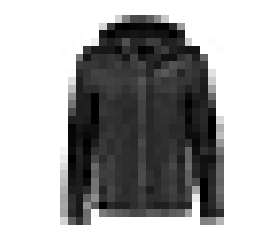

In [145]:
plt.imshow(X_train_normalized[0], cmap="binary")
plt.axis('off')
plt.show()

Unique values of y_train data:

In [19]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

List of class names to know what exactly each number depicts

In [20]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [21]:
class_names[y_train[0]]

'Coat'

Some samples from the MNIST Fashion dataset

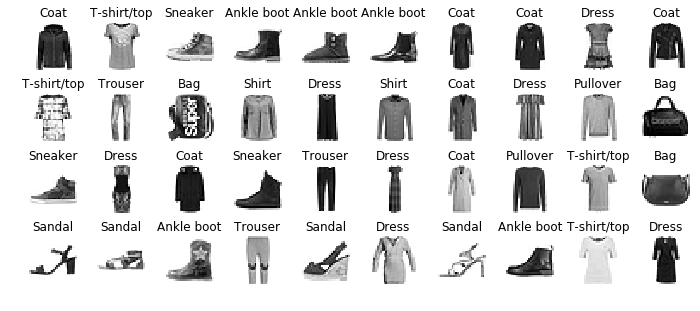

In [22]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train_normalized[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Train a simple model

## Initialize the model and its architecture

In [23]:
model_simple = keras.models.Sequential()
model_simple.add(keras.layers.Flatten(input_shape=[28, 28]))
model_simple.add(keras.layers.Dense(300, activation="relu"))
model_simple.add(keras.layers.Dense(100, activation="relu"))
model_simple.add(keras.layers.Dense(10, activation="softmax"))

Reset all state generated by Keras (if a model was initiated previously)

In [24]:
keras.backend.clear_session()

In [25]:
model_simple = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu", kernel_initializer='he_uniform'),
    keras.layers.Dense(100, activation="relu", kernel_initializer='he_uniform'),
    keras.layers.Dense(10, activation="softmax")
])

Get model's list of layers

In [26]:
model_simple.layers

Display model's summary: layers with their names, their output shape, and the number of parameters

In [27]:
model_simple.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Plot model's summary

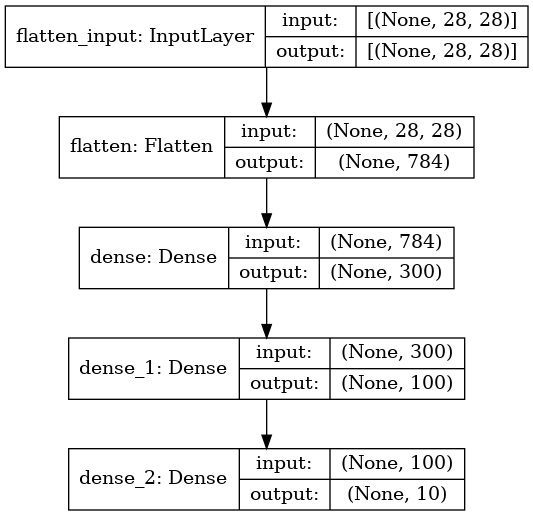

In [28]:
keras.utils.plot_model(model_simple, "fashion_mnist_model.png", show_shapes=True)

## Description of a layer (in this case, Dense) 

In [29]:
# name
hidden1 = model_simple.layers[1]
hidden1.name

'dense'

In [30]:
# check if it is hidden or not
model_simple.get_layer(hidden1.name) is hidden1

True

In [31]:
# get layer's weights and biases
weights, biases = hidden1.get_weights()

In [32]:
# weights' values
weights[5]

array([ 0.08638643,  0.01047292, -0.03106006,  0.03670789, -0.04781865,
        0.01388142,  0.02372251, -0.0502158 ,  0.02104162,  0.04844961,
        0.02953007, -0.05797079,  0.02882975,  0.08435396,  0.06137309,
       -0.0365416 ,  0.02144235,  0.03960829,  0.00081158, -0.08108427,
       -0.0193755 , -0.00564279,  0.06111278,  0.0663498 , -0.07500501,
       -0.07678579,  0.02225731,  0.0064536 ,  0.04960679, -0.05605847,
       -0.07255901, -0.00733271, -0.05567595, -0.02564432,  0.0840748 ,
        0.05180534,  0.0775819 , -0.03256639,  0.08727967, -0.04939087,
       -0.02300654, -0.06733806, -0.04634434, -0.04670567, -0.04453361,
        0.07660349,  0.05580015, -0.06644477,  0.05343934,  0.02162214,
        0.02110711,  0.05253082, -0.01028174,  0.02007417,  0.02403441,
        0.00990935, -0.07899092,  0.01655593, -0.0666851 , -0.06202734,
        0.05867659,  0.0347885 ,  0.01871238,  0.03217603, -0.03072682,
        0.00838172, -0.03927466,  0.0050872 , -0.06909116, -0.03

In [33]:
# weights' shape
weights.shape

(784, 300)

In [34]:
# biases values
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [35]:
# biases' values
biases.shape

(300,)

## Compile the model

In [36]:
model_simple.compile(loss=model_params["loss"], 
                     optimizer=model_params["optimizer"], 
                     metrics=model_params["metrics"])

## Train the model

In [37]:
history_simple = model_simple.fit(X_train_normalized, y_train, epochs=model_params["n_epochs"], 
                                  validation_data=(X_valid_normalized, y_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4992 - accuracy: 0.8229 - val_loss: 0.3757 - val_accuracy: 0.8650
Epoch 2/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3727 - accuracy: 0.8628 - val_loss: 0.3617 - val_accuracy: 0.8702
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3372 - accuracy: 0.8758 - val_loss: 0.3409 - val_accuracy: 0.8754
Epoch 4/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3143 - accuracy: 0.8837 - val_loss: 0.3167 - val_accuracy: 0.8854
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2976 - accuracy: 0.8892 - val_loss: 0.3160 - val_accuracy: 0.8818
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2808 - accuracy: 0.8964 - val_loss: 0.3110 - val_accuracy: 0.8898
Epoch 7/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2697 - accuracy: 0.8993 - val_loss: 0.3068 - val_accuracy:

Training parameters

In [38]:
history_simple.params

{'verbose': 1, 'epochs': 20, 'steps': 1719}

Training epochs

In [39]:
print(history_simple.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


Training keys of the metrics

In [40]:
history_simple.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Train evaluation though the epochs

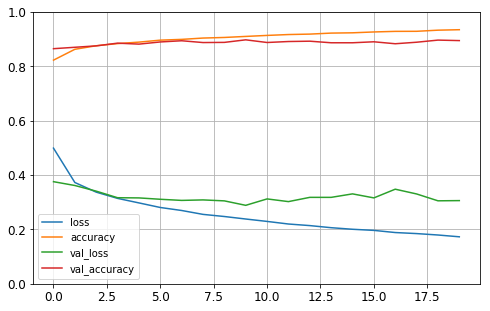

In [41]:
pd.DataFrame(history_simple.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Evaluate the model on the Test data

**Model accuracy**

Evaluate on test data

In [42]:
model_simple.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 63.0085 - accuracy: 0.8516


[63.00847625732422, 0.8515999913215637]

The prediction of the model is at: **83.93%**

Make the predictions based on the unseen test data

In [43]:
predictions = np.argmax(model_simple.predict(X_test_normalized, verbose=1), axis=-1)

313/313 [==============================] - 0s 620us/step


Shape of predictions

In [44]:
predictions.shape

(10000,)

Confusion matrix

In [45]:
print(confusion_matrix(y_test, predictions))

[[807   2  17  37   5   1 126   0   5   0]
 [  1 978   2  13   3   0   2   0   1   0]
 [ 11   1 781  21 111   1  74   0   0   0]
 [ 14   6   6 934  21   0  16   0   3   0]
 [  0   1  52  31 854   0  61   0   1   0]
 [  0   0   0   1   0 966   0  22   1  10]
 [ 82   0  58  44  75   0 734   0   7   0]
 [  0   0   0   0   0   8   0 974   0  18]
 [  7   1   1   8   2   3   5   4 969   0]
 [  1   0   0   0   0   6   0  44   0 949]]


Classification report

In [46]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.85      0.78      0.81      1000
           3       0.86      0.93      0.89      1000
           4       0.80      0.85      0.82      1000
           5       0.98      0.97      0.97      1000
           6       0.72      0.73      0.73      1000
           7       0.93      0.97      0.95      1000
           8       0.98      0.97      0.98      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



# Monte Carlo (MC) Dropout

Reset all state generated by Keras

In [61]:
# keras.backend.clear_session()

Add Dropout layers

In [62]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

Compile the model

In [63]:
model.compile(loss=model_params["loss"], 
              optimizer=model_params["optimizer"], 
              metrics=model_params["metrics"])

Train the model

In [64]:
history = model.fit(X_train_normalized, y_train, epochs=model_params["n_epochs"],
                    validation_data=(X_valid_normalized, y_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6237 - accuracy: 0.7726 - val_loss: 0.4187 - val_accuracy: 0.8484
Epoch 2/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4803 - accuracy: 0.8219 - val_loss: 0.3864 - val_accuracy: 0.8572
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4449 - accuracy: 0.8363 - val_loss: 0.3703 - val_accuracy: 0.8640
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4214 - accuracy: 0.8441 - val_loss: 0.3376 - val_accuracy: 0.8764
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4048 - accuracy: 0.8510 - val_loss: 0.3305 - val_accuracy: 0.8756
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3933 - accuracy: 0.8559 - val_loss: 0.3282 - val_accuracy: 0.8816
Epoch 7/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3810 - accuracy: 0.8577 - val_loss: 0.3276 - val_accuracy:

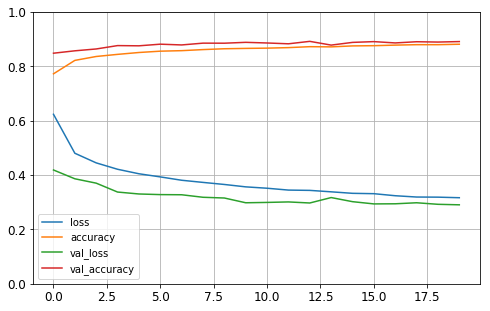

In [65]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

**Do the MC Dropout "trick" by setting the `training` to `True` and**:

- a) make 100 predictions over the test set
- b) stack the predictions


In [66]:
y_probas = np.stack([model(X_test_normalized, training=True) for sample in tqdm(range(100))])

**For each instance of the test set, compute the mean of the 100 exported probabilities, as well as the standard deviation**

In [67]:
y_proba = y_probas.mean(axis=0)

In [68]:
y_std = y_probas.std(axis=0)

### Predict the same signle instance as before

Predict in the same was as previously with `softmax`

In [69]:
y_proba_softmax = model.predict(X_test_normalized[0:1])
y_proba_softmax.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.94]],
      dtype=float32)

Print the first 3 probabilities' distribution from the 100 predicted outputs of that instance

In [70]:
np.round(y_probas[:, 0:1], 2)[:3]

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.94]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.44, 0.  , 0.54]]],
      dtype=float32)

In [71]:
print("Shape of the 100 probability predictions for this instance:", np.round(y_probas[:, 0:1], 2).shape)

Shape of the 100 probability predictions for this instance: (100, 1, 10)


**Predict the class for this instance**

This step is critical as it is also useful to know exactly which other classes it thinks are likely.

In [72]:
np.round(y_proba[0:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.14, 0.  , 0.85]],
      dtype=float32)

Take a look at the standard deviation of the probability estimates for this istance

In [73]:
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.14, 0.  , 0.15]],
      dtype=float32)

Hold the predicted classes by return the maximum value from each probability estimate

In [74]:
y_pred = np.argmax(y_proba, axis=1)

**Model's accuracy is now improved**

In [75]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8809

**The model's accuracy got a little boost with this method: 88.09%**

### Force the Dropout's `training` argument to `True`  by overriding the `call()` method 

In [76]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

**Because the model is already trained, the Dropout layers are replaced with the MCDropout, and the trained model's weights are set to the new model in order to run again the predictions**

In [77]:
mc_model = keras.models.Sequential([
    MCDropout(layer.rate) if isinstance(layer, keras.layers.Dropout) else layer
    for layer in model.layers
])

In [78]:
mc_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
mc_dropout (MCDropout)       (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
mc_dropout_1 (MCDropout)     (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
mc_dropout_2 (MCDropout)     (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

In [79]:
mc_model.compile(loss=model_params["loss"], 
                 optimizer=model_params["optimizer"], 
                 metrics=model_params["metrics"])

Set the Monte Carlo updated model's weights with these from pre-trained one

In [80]:
mc_model.set_weights(model.get_weights())

Use the model straightforward with MC Dropout layer to predict the unique instance's class

In [81]:
np.round(np.mean([mc_model.predict(X_test_normalized[0:1]) for sample in tqdm(range(100))], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.12, 0.  , 0.87]],
      dtype=float32)

## CNNs using the MCDropout

Transform the data to fit the CNN's dimension expectations

In [82]:
X_train_normalized_cnn = X_train_normalized[..., np.newaxis]
X_valid_normalized_cnn = X_valid_normalized[..., np.newaxis]
X_test_normalized_cnn = X_test_normalized[..., np.newaxis]

In [83]:
print("X train normalized data shape:", X_train_normalized_cnn.shape)
print("X validation normalized data shape:", X_valid_normalized_cnn.shape)
print("X test normalized data shape:", X_test_normalized_cnn.shape)
print("X train normalized max value:", X_train_normalized_cnn.max())
print("X train normalized min value:", X_train_normalized_cnn.min())

X train normalized data shape: (55000, 28, 28, 1)
X validation normalized data shape: (5000, 28, 28, 1)
X test normalized data shape: (10000, 28, 28, 1)
X train normalized max value: 1.0
X train normalized min value: 0.0


Reset all state generated by Keras

In [84]:
keras.backend.clear_session()

### Build and train a CNN model

In [85]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(Dropout(0.5))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform'))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(100, kernel_initializer='he_uniform'))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(10, activation='softmax'))

In [86]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        2

In [87]:
model_cnn.compile(loss=model_params["loss"], 
                  optimizer=model_params["optimizer"], 
                  metrics=model_params["metrics"])

In [88]:
history = model_cnn.fit(X_train_normalized_cnn, y_train, epochs=model_params["n_epochs"], 
                        validation_data=(X_valid_normalized_cnn, y_valid))

Epoch 1/20
1719/1719 [==============================] - 33s 19ms/step - loss: 0.5594 - accuracy: 0.7985 - val_loss: 0.5894 - val_accuracy: 0.7926
Epoch 2/20
1719/1719 [==============================] - 32s 19ms/step - loss: 0.3947 - accuracy: 0.8587 - val_loss: 0.3999 - val_accuracy: 0.8580
Epoch 3/20
1719/1719 [==============================] - 32s 19ms/step - loss: 0.3566 - accuracy: 0.8715 - val_loss: 0.4392 - val_accuracy: 0.8472
Epoch 4/20
1719/1719 [==============================] - 32s 19ms/step - loss: 0.3275 - accuracy: 0.8822 - val_loss: 0.4119 - val_accuracy: 0.8532
Epoch 5/20
1719/1719 [==============================] - 33s 19ms/step - loss: 0.3056 - accuracy: 0.8901 - val_loss: 0.3663 - val_accuracy: 0.8772
Epoch 6/20
1719/1719 [==============================] - 33s 19ms/step - loss: 0.2942 - accuracy: 0.8931 - val_loss: 0.4056 - val_accuracy: 0.8536
Epoch 7/20
1719/1719 [==============================] - 32s 19ms/step - loss: 0.2828 - accuracy: 0.8976 - val_loss: 0.3855 -

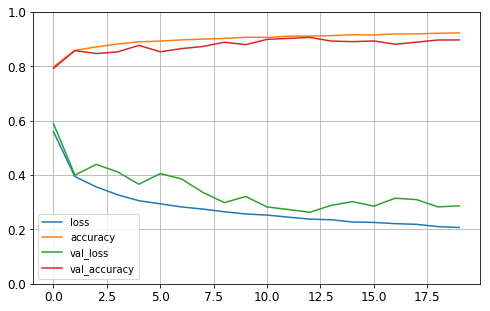

In [89]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

**Model accuracy**

In [90]:
# evaluate the model on test dataset
loss, acc = model_cnn.evaluate(X_test_normalized_cnn, y_test, verbose=1)
print('> %.3f' % (acc * 100.0))

313/313 [==============================] - 1s 4ms/step - loss: 0.3260 - accuracy: 0.8797
> 87.970


**Model instance prediction with `softmax`**

In [91]:
y_proba_softmax = model_cnn.predict(X_test_normalized_cnn[0:1])
y_proba_softmax.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

### Create the MC CNN model and transfer the weights from the previous CNN model

In [92]:
mc_model_cnn = keras.models.Sequential([
    MCDropout(layer.rate) if isinstance(layer, keras.layers.Dropout) else layer
    for layer in model_cnn.layers
])

In [93]:
mc_model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
mc_dropout (MCDropout)       (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)       

In [94]:
mc_model_cnn.compile(loss=model_params["loss"], 
                     optimizer=model_params["optimizer"], 
                     metrics=model_params["metrics"])

In [95]:
mc_model_cnn.set_weights(model_cnn.get_weights())

### Predictions

Use the model straightforward with MC Dropout layer to predict the unique instance's class

In [96]:
np.round(np.mean([mc_model_cnn.predict(X_test_normalized_cnn[0:1]) for sample in tqdm(range(100))], axis=0), 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

Stack the probabilities for all the instances

In [97]:
y_probas = np.stack([mc_model_cnn(X_test_normalized_cnn) for sample in tqdm(range(100))])

Compute the mean and std for the instances' probability estimates

In [98]:
y_proba = y_probas.mean(axis=0)

In [99]:
y_std = y_probas.std(axis=0)

Show the probabilities for an instance (the same as above)

In [100]:
np.round(y_probas[:, 0:1], 2)[:3]

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]], dtype=float32)

In [101]:
print("Shape of the 100 probability predictions for this instance:", np.round(y_probas[:, 0:1], 2).shape)

Shape of the 100 probability predictions for this instance: (100, 1, 10)


**Predict the class for this instance**

This step is critical as it is also useful to know exactly which other classes it thinks are likely.

In [102]:
np.round(y_proba[0:1], 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

Take a look at the standard deviation of the probability estimates for this istance

In [103]:
np.round(y_std[0:1], 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Hold the predicted classes by return the maximum value from each probability estimate

In [104]:
y_pred = np.argmax(y_proba, axis=1)

**Model's accuracy is now improved**

In [105]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.9164

**Model's accuracy is improved: 91.49%**

## Build and train an MC CNN model

Reset all state generated by Keras

In [106]:
keras.backend.clear_session()

In [107]:
model_mc_cnn = Sequential()
model_mc_cnn.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model_mc_cnn.add(BatchNormalization())
model_mc_cnn.add(Activation("relu"))
model_mc_cnn.add(MCDropout(0.5))
model_mc_cnn.add(MaxPooling2D((2, 2)))
model_mc_cnn.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model_mc_cnn.add(BatchNormalization())
model_mc_cnn.add(Activation("relu"))
model_mc_cnn.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform'))
model_mc_cnn.add(BatchNormalization())
model_mc_cnn.add(Activation("relu"))
model_mc_cnn.add(MaxPooling2D((2, 2)))
model_mc_cnn.add(Flatten())
model_mc_cnn.add(Dense(100, kernel_initializer='he_uniform'))
model_mc_cnn.add(BatchNormalization())
model_mc_cnn.add(Activation("relu"))
model_mc_cnn.add(MCDropout(0.5))
model_mc_cnn.add(Dense(10, activation='softmax'))

In [108]:
model_mc_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
mc_dropout (MCDropout)       (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        2

In [109]:
model_mc_cnn.compile(loss=model_params["loss"], 
                     optimizer=model_params["optimizer"], 
                     metrics=model_params["metrics"])

In [110]:
history = model_mc_cnn.fit(X_train_normalized_cnn, y_train, epochs=model_params["n_epochs"], 
                           validation_data=(X_valid_normalized_cnn, y_valid))

Epoch 1/20
1719/1719 [==============================] - 34s 20ms/step - loss: 0.5694 - accuracy: 0.7929 - val_loss: 0.4031 - val_accuracy: 0.8514
Epoch 2/20
1719/1719 [==============================] - 34s 20ms/step - loss: 0.4095 - accuracy: 0.8531 - val_loss: 0.3517 - val_accuracy: 0.8700
Epoch 3/20
1719/1719 [==============================] - 31s 18ms/step - loss: 0.3649 - accuracy: 0.8680 - val_loss: 0.3395 - val_accuracy: 0.8776
Epoch 4/20
1719/1719 [==============================] - 32s 18ms/step - loss: 0.3365 - accuracy: 0.8778 - val_loss: 0.3630 - val_accuracy: 0.8648
Epoch 5/20
1719/1719 [==============================] - 30s 18ms/step - loss: 0.3141 - accuracy: 0.8864 - val_loss: 0.3077 - val_accuracy: 0.8874
Epoch 6/20
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2996 - accuracy: 0.8929 - val_loss: 0.3093 - val_accuracy: 0.8922
Epoch 7/20
1719/1719 [==============================] - 30s 18ms/step - loss: 0.2912 - accuracy: 0.8942 - val_loss: 0.3191 -

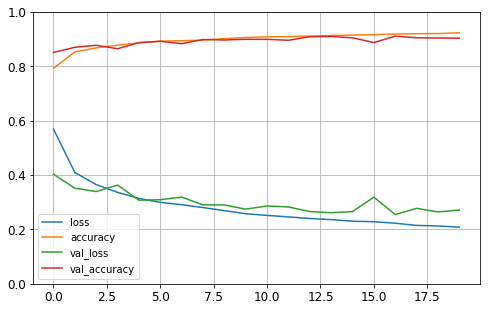

In [111]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

**Model accuracy**

In [112]:
# evaluate the model on test dataset
loss, acc = model_mc_cnn.evaluate(X_test_normalized_cnn, y_test, verbose=1)
print('> %.3f' % (acc * 100.0))

313/313 [==============================] - 2s 6ms/step - loss: 0.2987 - accuracy: 0.8923
> 89.230


### Predictions

Use `numpy.squeeze()` to remove all dimensions of size 1 from the NumPy array `ndarray`. `squeeze()` is also provided as a method of `ndarray`.

In [113]:
X_test_normalized_instance = np.squeeze(X_test_normalized_cnn[10])
print(X_test_normalized_instance.shape)

(28, 28)


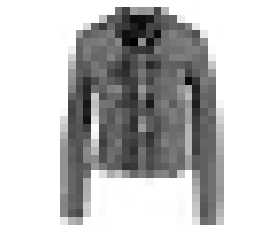

In [114]:
plt.imshow(X_test_normalized_instance, cmap="binary")
plt.axis('off')
plt.show()

In [115]:
class_names[y_test[10]

'Coat'

Use the model straightforward with MC Dropout layer to predict a unique instance's class

In [116]:
y_pred_mc_cnn = np.round(np.mean([model_mc_cnn.predict(X_test_normalized_cnn[10:11]) 
                                  for sample in tqdm(range(100))], axis=0), 2)
print(y_pred_mc_cnn)


[[0.   0.   0.02 0.   0.89 0.   0.08 0.   0.   0.  ]]


In [117]:
y_pred_mc_cnn_instance = np.argmax(y_pred_mc_cnn, axis=-1)

In [118]:
np.array(class_names)[y_pred_mc_cnn_instance]

array(['Coat'], dtype='<U11')

Stack the probabilities for all the instances

In [119]:
y_probas = np.stack([model_mc_cnn(X_test_normalized_cnn) for sample in tqdm(range(100))])

Compute the mean and std for the instances' probability estimates

In [120]:
y_proba = y_probas.mean(axis=0)

In [121]:
y_std = y_probas.std(axis=0)

Show the probabilities for an instance (the same as above)

In [122]:
np.round(y_probas[:, 10:11], 2)[:3]

array([[[0.  , 0.  , 0.03, 0.  , 0.91, 0.  , 0.06, 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.02, 0.  , 0.9 , 0.  , 0.08, 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.97, 0.  , 0.02, 0.  , 0.  , 0.  ]]],
      dtype=float32)

In [123]:
print("Shape of the 100 probability predictions for this instance:", np.round(y_probas[:, 10:11], 2).shape)

Shape of the 100 probability predictions for this instance: (100, 1, 10)


**Predict the class for this instance**

This step is critical as it is also useful to know exactly which other classes it thinks are likely.

In [124]:
np.round(y_proba[10:11], 2)

array([[0.  , 0.  , 0.02, 0.  , 0.9 , 0.  , 0.08, 0.  , 0.  , 0.  ]],
      dtype=float32)

Take a look at the standard deviation of the probability estimates for this istance

In [125]:
np.round(y_std[10:11], 2)

array([[0.  , 0.  , 0.03, 0.  , 0.09, 0.  , 0.08, 0.  , 0.  , 0.  ]],
      dtype=float32)

Hold the predicted classes by return the maximum value from each probability estimate

In [126]:
y_pred = np.argmax(y_proba, axis=1)

**Model's accuracy is now improved**

In [127]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.9091

## Make prediction for  single instances

### Instance 01

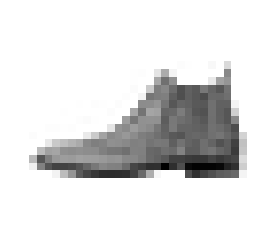

In [47]:
plt.imshow(X_test_normalized[0], cmap="binary")
plt.axis('off')
plt.show()

In [147]:
class_names[y_test[00]]

'Ankle boot'

#### Simple Model

In [48]:
y_proba_softmax = model.predict(X_test_normalized[0:1])
y_proba_softmax.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [49]:
y_pred = np.argmax(model.predict(X_test_normalized[0:1]), axis=-1)
y_pred

array([9])

In [50]:
np.array(class_names)[y_pred]

array(['Ankle boot'], dtype='<U11')

### Instance 02

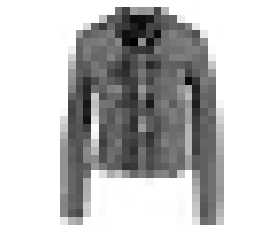

In [51]:
plt.imshow(X_test_normalized[10], cmap="binary")
plt.axis('off')
plt.show()

In [146]:
class_names[y_test[10]]

'Coat'

#### Simple Model

In [52]:
y_proba_softmax = model.predict(X_test_normalized[10:11])
y_proba_softmax.round(2)

array([[0.  , 0.  , 0.07, 0.  , 0.93, 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [53]:
y_pred = np.argmax(model.predict(X_test_normalized[10:11]), axis=-1)
y_pred

array([4])

In [54]:
np.array(class_names)[y_pred]

array(['Coat'], dtype='<U11')

## Make a prediction for a batch of instances

In [148]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [149]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [55]:
test_indices = range(3,7)
list(test_indices)

[3, 4, 5, 6]

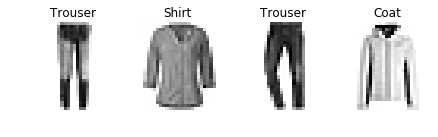

In [56]:
plt.figure(figsize=(7.2, 2.4))
for index, image_number in enumerate(list(test_indices)):
    plt.subplot(1, 4, index + 1)
    plt.imshow(X_test_normalized[image_number], cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[image_number]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [57]:
y_test[3:7]

array([1, 6, 1, 4], dtype=uint8)

### Simple model

In [58]:
y_proba_softmax = model.predict(X_test_normalized[3:7])
y_proba_softmax.round(2)

array([[0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.06, 0.  , 0.  , 0.  , 0.  , 0.  , 0.94, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [59]:
y_pred = np.argmax(model.predict(X_test_normalized[3:7]), axis=-1)
y_pred

array([1, 6, 1, 4])

In [60]:
np.array(class_names)[y_pred]

array(['Trouser', 'Shirt', 'Trouser', 'Coat'], dtype='<U11')

## Load MNIST with digits

In [128]:
digits_mnist = keras.datasets.mnist

In [129]:
(X_train_digits, y_train_digits), (X_test_digits, y_test_digits) = digits_mnist.load_data()

In [130]:
print("Digits - X train shape:", X_train_digits.shape)
print("Digits - X test shape:", X_test_digits.shape)
print("Digits - y train shape:", X_test_digits.shape)
print("Digits - y test shape:", y_test_digits.shape)

Digits - X train shape: (60000, 28, 28)
Digits - X test shape: (10000, 28, 28)
Digits - y train shape: (10000, 28, 28)
Digits - y test shape: (10000,)


In [131]:
X_train_digits_nrm = normalize_pics(X_train_digits)
X_test_digits_nrm = normalize_pics(X_test_digits)

In [132]:
print("Digits - X train normalized shape:", X_train_digits_nrm.shape)
print("Digits - X test normalized shape:", X_test_digits_nrm.shape)
print("Digits - X test max normalized value:", X_test_digits_nrm.max())
print("Digits - X test min normalized value:", X_test_digits_nrm.min())

Digits - X train normalized shape: (60000, 28, 28)
Digits - X test normalized shape: (10000, 28, 28)
Digits - X test max normalized value: 1.0
Digits - X test min normalized value: 0.0


In [133]:
X_train_digits_nrm_cnn = X_train_digits_nrm[..., np.newaxis]
X_test_digits_nrm_cnn = X_test_digits_nrm[..., np.newaxis]

In [135]:
X_test_digits_nrm_instance = np.squeeze(X_test_digits_nrm_cnn[0])
print("Shape of digit instance", X_test_normalized_instance.shape)
print("label:", y_test_digits[0])

Shape of digit instance (28, 28)
label: 7


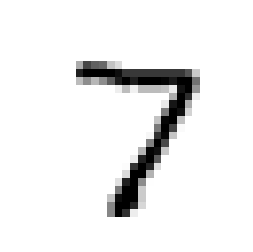

In [136]:
plt.imshow(X_test_digits_nrm_instance, cmap="binary")
plt.axis('off')
plt.show()

In [138]:
y_pred_mc_cnn_digit = np.round(np.mean([model_mc_cnn.predict(X_test_digits_nrm_cnn[0:1]) 
                                  for sample in tqdm(range(100))], axis=0), 2)
print(y_pred_mc_cnn_digit)


[[0.21 0.   0.   0.01 0.   0.47 0.02 0.   0.24 0.03]]


In [139]:
X_test_digits_nrm_instance = np.squeeze(X_test_digits_nrm_cnn[1])
print("Shape of digit instance", X_test_normalized_instance.shape)
print("label:", y_test_digits[1])

Shape of digit instance (28, 28)
label: 2


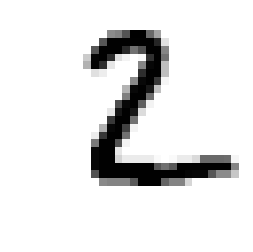

In [140]:
plt.imshow(X_test_digits_nrm_instance, cmap="binary")
plt.axis('off')
plt.show()

In [141]:
y_pred_mc_cnn_digit = np.round(np.mean([model_mc_cnn.predict(X_test_digits_nrm_cnn[1:2]) 
                                  for sample in tqdm(range(100))], axis=0), 2)
print(y_pred_mc_cnn_digit)


[[0.15 0.02 0.2  0.02 0.1  0.07 0.01 0.1  0.31 0.03]]


In [142]:
X_test_digits_nrm_instance = np.squeeze(X_test_digits_nrm_cnn[2])
print("Shape of digit instance", X_test_normalized_instance.shape)
print("label:", y_test_digits[2])

Shape of digit instance (28, 28)
label: 1


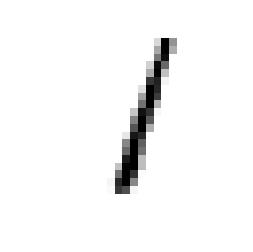

In [143]:
plt.imshow(X_test_digits_nrm_instance, cmap="binary")
plt.axis('off')
plt.show()

In [144]:
y_pred_mc_cnn_digit = np.round(np.mean([model_mc_cnn.predict(X_test_digits_nrm_cnn[2:3]) 
                                  for sample in tqdm(range(100))], axis=0), 2)
print(y_pred_mc_cnn_digit)


[[0.05 0.26 0.   0.06 0.01 0.11 0.11 0.31 0.05 0.04]]
